# Meent Tutorial 1
 Modeling and Electromagnetic simulation

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np

import meent

In [2]:
# common
pol = 0  # 0: TE, 1: TM

n_I = 1  # n_incidence
n_II = 1  # n_transmission

theta = 20 * np.pi / 180
phi = 50 * np.pi / 180

wavelength = 900

thickness = [500]
period = [1000]

fourier_order = [30]

type_complex = np.complex128

grating_type = 0

## 1.1 Modeling

ucell (unit cell) is a 3-dimensional array which has refractive index elements. It supports complex index, 2-dimensional grating and multi-layered structures.

The order of dimensions: Z Y X.


        ______________________
       |\                     \
       | \                     \  Y
       |  \                     \
       |\  \_____________________\
       | \ |      Layer 1        |
       \  \|_____________________|
        \  |                     | Z
         \ |      Layer 2        |
          \|_____________________|
                     X

- Z: Height of the structure
ucell[*, :, :]
ucell[0, :, :] means the top layer which directly encounters the incident wave.

- Y: Depth of the structure
ucell[:, *, :]
2 dimensional grating is implemented on this and the last axes.
For 1 dimensional case, this length is fixed to 1(index is zero) and not used.

- X: Width of the structure
ucell[:, :, *]
This is the default axis. 1 dimensional grating is implemented on this axis.



In [3]:
ucell_1d_s = np.array([
    [
        [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, ],
    ],
]) * 4 + 1  # refractive index

1D grating, single layer

In [4]:
ucell_1d_m = np.array([
    [
        [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, ],
    ],
    [
        [1, 1, 1, 1, 1, 0, 1, 0, 1, 0, ],
    ],
    [
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 1, ],
    ],
]) * 4 + 1  # refractive index

1D grating, multi layer

In [5]:
ucell_2d_s = np.array([
    [
        [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, ],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ],
    ],
]) * 4 + 1  # refractive index

2D grating, single layer

In [6]:
ucell_2d_m = np.array([
    [
        [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, ],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ],
    ],
    [
        [1, 1, 0, 1, 1, 0, 1, 0, 2, 1, ],
        [0, 1, 1, 1, 2, 4, 1, 0, 1, 1, ],
    ],
    [
        [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, ],
        [1, 1, 1, 2, 0, 1, 2, 0, 1, 1, ],
    ],
    [
        [0, 1, 0, 1, 1, 1, 1, 0, 1, 1, ],
        [0, 1, 3, 1, 1, 1, 1, 1, 1, 1, ],
    ],
]) * 4 + 1  # refractive index

2D grating, multi layer

## 1.2 EM Simulation

In [7]:
mee = meent.call_mee(backend=0, grating_type=grating_type, pol=pol, n_I=n_I, n_II=n_II, theta=theta, phi=phi, fourier_order=fourier_order, wavelength=wavelength, period=period, ucell=ucell_1d_s, thickness=thickness, type_complex=type_complex, fft_type=0, improve_dft=True)

call meent operator by `meent.call_mee`.
Here, backend can be selected with keyword `backend`

```python
backend = 0  # Numpy backend
backend = 1  # JAX backend
backend = 2  # PyTorch backend
```


### Diffraction Efficiency

In [8]:
t0 = time.time()
de_ri, de_ti = mee.conv_solve()
print(f'time: ', time.time() - t0)

time:  0.00780797004699707


In [9]:
center = de_ri.shape[0] // 2

print('Diffraction Efficiency of Reflection:', np.round(de_ri[center-1:center+2], 3))
print('Diffraction Efficiency of Transmission:', np.round(de_ti[center-1:center+2], 3))

Diffraction Efficiency of Reflection: [0.    0.803 0.   ]
Diffraction Efficiency of Transmission: [0.    0.197 0.   ]


### Field Distribution

In [10]:
resolution = (100, 1, 100)

t0 = time.time()
field_cell = mee.calculate_field(resolution=resolution, plot=False)
print(f'time: ', time.time() - t0)

time:  0.0530240535736084


#### ZX direction (Side View)

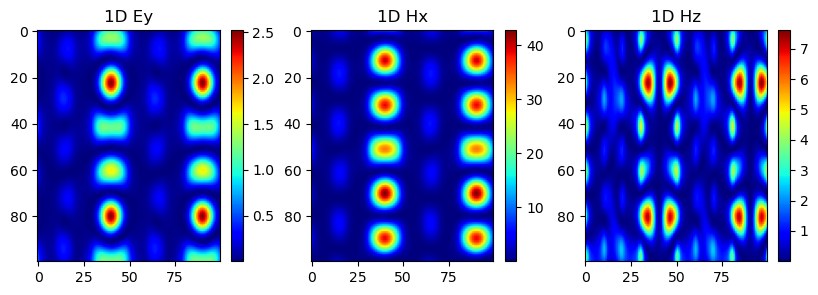

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(10,3))
if pol == 0:  # TE
    title = ['1D Ey', '1D Hx', '1D Hz', ]
else:  # TM
    title = ['1D Hy', '1D Ex', '1D Ez', ]

for ix in range(len(title)):
    val = abs(field_cell[:, 0, :, ix]) ** 2
    im = axes[ix].imshow(val, cmap='jet', aspect='auto')
    # plt.clim(0, 2)  # identical to caxis([-4,4]) in MATLAB
    fig.colorbar(im, ax=axes[ix], shrink=1)
    axes[ix].title.set_text(title[ix])

plt.show()

#### YZ Direction (Top View)

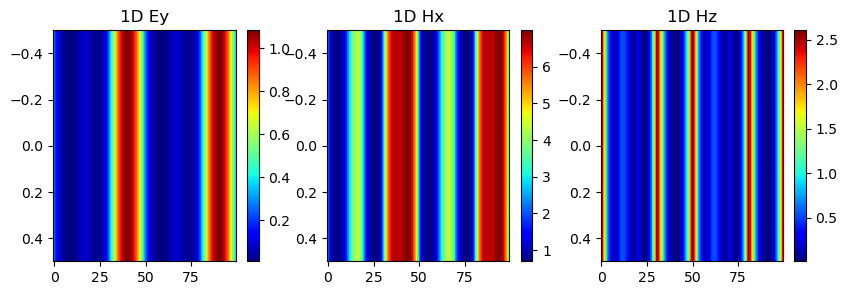

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(10,3))
if pol == 0:  # TE
    title = ['1D Ey', '1D Hx', '1D Hz', ]
else:  # TM
    title = ['1D Hy', '1D Ex', '1D Ez', ]

for ix in range(len(title)):
    val = abs(field_cell[0, :, :, ix]) ** 2
    im = axes[ix].imshow(val, cmap='jet', aspect='auto')
    # plt.clim(0, 2)  # identical to caxis([-4,4]) in MATLAB
    fig.colorbar(im, ax=axes[ix], shrink=1)
    axes[ix].title.set_text(title[ix])

plt.show()

## 1.3 Example: multilayer 2D

In [13]:
grating_type = 2
fourier_order = [10, 9]
thickness = [100, 200, 400, 245]
period = [1000, 2000]

ucell_2d_m = np.array([
    [
        [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, ],
        [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ],
    ],
    [
        [1, 1, 0, 1, 1, 0, 1, 0, 2, 1, ],
        [0, 1, 1, 1, 2, 4, 1, 0, 1, 1, ],
    ],
    [
        [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, ],
        [1, 1, 1, 2, 0, 1, 2, 0, 1, 1, ],
    ],
    [
        [0, 1, 0, 1, 1, 1, 1, 0, 1, 1, ],
        [0, 1, 3, 1, 1, 1, 1, 1, 1, 1, ],
    ],
]) * 4 + 1  # refractive index


In [14]:
mee = meent.call_mee(backend=0, grating_type=grating_type, pol=pol, n_I=n_I, n_II=n_II, theta=theta, phi=phi, fourier_order=fourier_order, wavelength=wavelength, period=period, ucell=ucell_2d_m, thickness=thickness, type_complex=type_complex, fft_type=0, improve_dft=True)

In [15]:
t0 = time.time()
de_ri, de_ti = mee.conv_solve()
print(f'time: ', time.time() - t0)

time:  13.280186891555786


In [16]:
center = de_ri.shape[0] // 2

print('Diffraction Efficiency of Reflection:\n', np.round(de_ri[center-1:center+2, center-1:center+2], 3))
print('Diffraction Efficiency of Transmission:\n', np.round(de_ti[center-1:center+2, center-1:center+2], 3))

Diffraction Efficiency of Reflection:
 [[0.    0.025 0.068]
 [0.    0.066 0.453]
 [0.    0.016 0.04 ]]
Diffraction Efficiency of Transmission:
 [[0.    0.105 0.054]
 [0.    0.055 0.005]
 [0.    0.002 0.008]]


In [17]:
resolution = (40, 40, 40)

t0 = time.time()
field_cell = mee.calculate_field(resolution=resolution, plot=False)
print(f'time: ', time.time() - t0)

time:  9.00914478302002


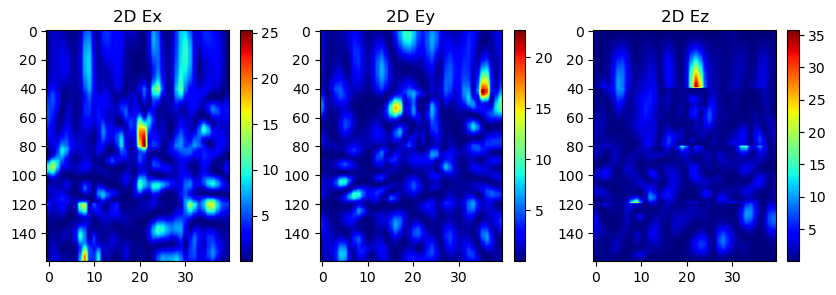

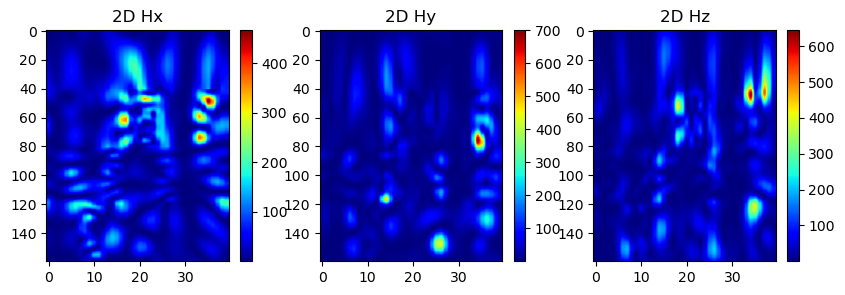

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(10,3))
title = ['2D Ex', '2D Ey', '2D Ez', '2D Hx', '2D Hy', '2D Hz', ]

for ix in range(3):
    val = abs(field_cell[:, 0, :, ix]) ** 2
    im = axes[ix].imshow(val, cmap='jet', aspect='auto')
    # plt.clim(0, 2)  # identical to caxis([-4,4]) in MATLAB
    fig.colorbar(im, ax=axes[ix], shrink=1)
    axes[ix].title.set_text(title[ix])

plt.show()

fig, axes = plt.subplots(1, 3, figsize=(10,3))
for ix in range(3, 6, 1):
    val = abs(field_cell[:, 0, :, ix]) ** 2
    im = axes[ix-3].imshow(val, cmap='jet', aspect='auto')
    # plt.clim(0, 2)  # identical to caxis([-4,4]) in MATLAB
    fig.colorbar(im, ax=axes[ix-3], shrink=1)
    axes[ix-3].title.set_text(title[ix])

plt.show()

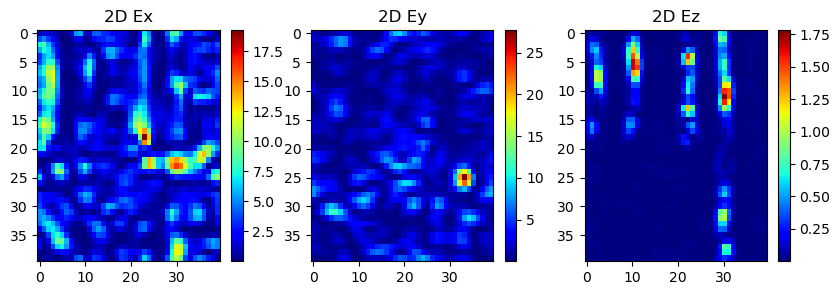

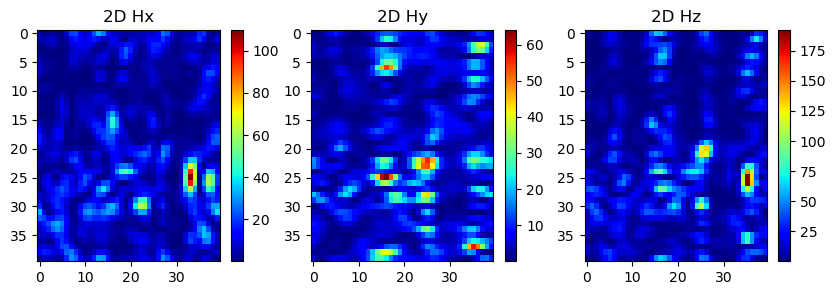

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(10,3))
title = ['2D Ex', '2D Ey', '2D Ez', '2D Hx', '2D Hy', '2D Hz', ]

for ix in range(3):
    val = abs(field_cell[0, :, :, ix]) ** 2
    im = axes[ix].imshow(val, cmap='jet', aspect='auto')
    # plt.clim(0, 2)  # identical to caxis([-4,4]) in MATLAB
    fig.colorbar(im, ax=axes[ix], shrink=1)
    axes[ix].title.set_text(title[ix])

plt.show()

fig, axes = plt.subplots(1, 3, figsize=(10,3))
for ix in range(3, 6, 1):
    val = abs(field_cell[0, :, :, ix]) ** 2
    im = axes[ix-3].imshow(val, cmap='jet', aspect='auto')
    # plt.clim(0, 2)  # identical to caxis([-4,4]) in MATLAB
    fig.colorbar(im, ax=axes[ix-3], shrink=1)
    axes[ix-3].title.set_text(title[ix])

plt.show()